In [1]:
import numpy as np
from lwa_antpos import reading, mapping
from lwa_f import snap2_fengine, snap2_feng_etcd_client
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

Read antpos from etcd


In [2]:
import pyuvdata

In [3]:
snap2names = ['snap01']  # snap01 is the only connected snap right now
for snap2name in snap2names:
    snap2num = int(snap2name.lstrip('snap'))
    lwa_f = snap2_fengine.Snap2Fengine(snap2name)

2021-10-13 18:43:01,556 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2021-10-13 18:43:01,836 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-10-13 18:43:02,148 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [4]:
Nblocks = 4
spec = []
for pol_block in range(Nblocks):
    spec_new = lwa_f.autocorr.get_new_spectra(pol_block)
    spec.append(spec_new)
spec = np.concatenate(spec, axis=0)

In [5]:
print(np.shape(spec)) # Shape (Nantpols, Nfreqs)
Nantpols = np.shape(spec)[0]
Nantpols_per_block = int(Nantpols/Nblocks)
Nfreqs = np.shape(spec)[1]
frequencies = np.linspace(0, 196/2, Nfreqs, endpoint=False)

(64, 4096)


In [6]:
antpol_names = np.empty(Nantpols, dtype='<U10')
use_index = 0
for pol_block in range(Nblocks):
    for ant_index in range(Nantpols_per_block):
        digitizer_input = ant_index+16*pol_block
        lwa_antname = mapping.digitizer_to_antpol(digitizer_input)
        antpol_names[use_index] = lwa_antname
        use_index += 1
print(antpol_names)

['LWA-213A' 'LWA-213B' 'LWA-224A' 'LWA-224B' 'LWA-215A' 'LWA-215B'
 'LWA-214A' 'LWA-214B' 'LWA-218A' 'LWA-218B' 'LWA-217A' 'LWA-217B'
 'LWA-223A' 'LWA-223B' 'LWA-219A' 'LWA-219B' 'LWA-226A' 'LWA-226B'
 'LWA-225A' 'LWA-225B' 'LWA-228A' 'LWA-228B' 'LWA-227A' 'LWA-227B'
 'LWA-230A' 'LWA-230B' 'LWA-229A' 'LWA-229B' 'LWA-232A' 'LWA-232B'
 'LWA-231A' 'LWA-231B' 'LWA-234A' 'LWA-234B' 'LWA-233A' 'LWA-233B'
 'LWA-236A' 'LWA-236B' 'LWA-235A' 'LWA-235B' 'LWA-238A' 'LWA-238B'
 'LWA-237A' 'LWA-237B' 'LWA-240A' 'LWA-240B' 'LWA-239A' 'LWA-239B'
 'LWA-242A' 'LWA-242B' 'LWA-241A' 'LWA-241B' 'LWA-244A' 'LWA-244B'
 'LWA-243A' 'LWA-243B' 'LWA-246A' 'LWA-246B' 'LWA-245A' 'LWA-245B'
 'LWA-248A' 'LWA-248B' 'LWA-247A' 'LWA-247B']


In [7]:
antenna_names = np.unique([name[:-1] for name in antpol_names])
Nants = len(antenna_names)
antenna_numbers = np.array([int(name[4:]) for name in antenna_names])

data_array = np.zeros((Nants, 1, Nfreqs, 2), dtype=complex)
for ant_ind, antname in enumerate(antenna_names):
    antpol_ind = np.where(antpol_names == f'{antname}A')
    data_array[ant_ind, 0, :, 0] = spec[antpol_ind, :]
    antpol_ind = np.where(antpol_names == f'{antname}B')
    data_array[ant_ind, 0, :, 1] = spec[antpol_ind, :]

In [8]:
spec2 = lwa_f.corr.get_new_corr(0,0) # 8 channel average
print(spec2.shape)

(512,)


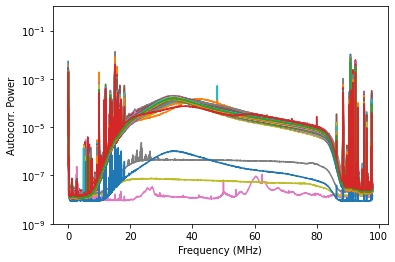

In [9]:
%matplotlib inline
for ant_ind in range(Nantpols):
    plt.plot(frequencies, spec[ant_ind,:])
plt.ylim([1.e-9,1.e0])
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Autocorr. Power')
plt.show()

In [11]:
uv = pyuvdata.UVData()
uv.Nants_data = Nants
uv.Nants_telescope = Nants  # This isn't right
uv.Nbls = uv.Nants_data
uv.Nblts = uv.Nants_data
uv.Nfreqs = len(frequencies)
uv.Npols = 2
uv.Nspws = 1
uv.Ntimes = 1
uv.ant_1_array = antenna_numbers
uv.ant_2_array = antenna_numbers
uv.antenna_names = antenna_names
uv.antenna_numbers = antenna_numbers
uv.baseline_array = 2048*(uv.ant_1_array+1) + (uv.ant_2_array+1) + 2**16
uv.telescope_name = 'OVRO-LWA'
uv.instrument = 'OVRO-LWA'
uv.vis_units = 'uncalib'
uv.data_array = data_array
uv.channel_width = 196./2/Nfreqs*10**6
uv.flag_array = np.zeros((Nants, 1, Nfreqs, 2), dtype=bool)
uv.freq_array = np.reshape(frequencies*10**6, (1, Nfreqs))
uv.history = 'LWA F-engine output autocorrs'
uv.nsample_array = np.ones((Nants, 1, Nfreqs, 2), dtype=float)
uv.polarization_array = np.array([-5, -6])
uv.spw_array = [0]
uv.telescope_location = np.array([-2409247.20369628, -4477889.56236559, 3839327.82827938])
uv.uvw_array = np.zeros((uv.Nblts, 3), dtype=float)
uv.phase_type = 'drift'

# Fill these with dummy variables so pyuvdata is happy
uv.antenna_positions = np.zeros((uv.Nants_telescope, 3))
uv.integration_time = np.zeros(uv.Nants_data, dtype=float)
uv.lst_array = np.zeros(uv.Nblts, dtype=float)
uv.object_name = ''
uv.time_array = np.zeros(uv.Nblts, dtype=float)

uv.check()

True

In [12]:
uv.write_uvfits(
    f'autocorr_snap01_{datetime.now().strftime("%m-%d-%Y_%H:%M")}.uvfits',
    force_phase=True,
    spoof_nonessential=True
)

The data are in drift mode and do not have a defined phase center. Phasing to zenith of the first timestamp.


ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
ERFA function "epv00" yielded 1 of "warning: date outsidethe range 1900-2100 AD"
ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
